In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.engines.toy as toys
import numpy as np
import pandas as pd

# Committors and Shooting Point Analysis

There are several ways that we can calculate committors. This deals with two, in particular.

First, we frequently want to run a committor from some specific snapshots. For example, you have a transition trajectory, and you want a sense of where the barrier is. So you select 10-20 frames from the trajectory, and run each of them 10-20 times with random velocities to see which states they end up in. The first section of this document describes how to do that process for any list of snapshots.

Second, we frequently want to plot the committor as a function of some collective variable(s). In this case, we can histogram a bunch of committor shots according to the desired CVs. And, since every shooting move is essentially a committor trial, we can histogram *all* the shooting points from a normal path sampling calculation to obtain the committor landscape. This is what we do in the second section of this document.

Note that there are also tricks to get the committor based on the reweighted path ensemble, and if you're really trying to get the committor landscape in some collective variables, that will probably be the best approach. The approaches here are useful for more simple analyses and for troubleshooting while setting up path sampling simulations.

## Simple Committor Run

The analysis we use for the committor can be used on shooting points in general, but often we just want to run a committor calculation directly. Here we set up a simple run in a situation where, if the forward extension is chosen, we always end up in the `right` state, and if the backward extension is chosen, we always end up in the `left` state.

In [2]:
pes = toys.LinearSlope(m=[0.0], c=[0.0]) # flat line
topology = toys.Topology(n_spatial=1, masses=[1.0], pes=pes)
integrator = toys.LeapfrogVerletIntegrator(0.1)
options = {
    'integ': integrator,
    'n_frames_max': 1000,
    'n_steps_per_frame': 5
}

engine = toys.Engine(options=options, topology=topology)

snap0 = toys.Snapshot(coordinates=np.array([[0.0]]),
                      velocities=np.array([[1.0]]),
                      engine=engine)
snap1 = toys.Snapshot(coordinates=np.array([[0.2]]),
                      velocities=np.array([[1.0]]),
                      engine=engine)


cv = paths.FunctionCV("Id", lambda snap : snap.coordinates[0][0])

# these are our states:
left = paths.CVDefinedVolume(cv, float("-inf"), -1.0).named("left")
right = paths.CVDefinedVolume(cv, 1.0, float("inf")).named("right")

# set up a file for storage
storage = paths.Storage("committor_test.nc", mode="w", template=snap0)

In addition to the standard setup as above, we need a way to randomize the snapshots. For this simple example, we actually won't randomize them (`NoModification`), but typically we would assign totally random velocities from a Boltzmann distribution (`RandomVelocities`).

In [3]:
## more typical:
#randomizer = paths.RandomVelocities(beta=1.0)
## for testing purposes:
randomizer = paths.NoModification()

Now we set up the committor simulation and run it. In this example, we use a list of two snapshots. If you only want to do the committor from one snapshot, you don't have to wrap it in a list.

In [4]:
simulation = paths.CommittorSimulation(storage=storage,
                                       engine=engine,
                                       states=[left, right],
                                       randomizer=randomizer,
                                       initial_snapshots=[snap0, snap1])
simulation.run(n_per_snapshot=10)

Now we do the analysis:

In [5]:
results = paths.ShootingPointAnalysis(steps=storage.steps, states=[left, right])
results[snap0]

Counter({<openpathsampling.volume.CVDefinedVolume at 0x1174d3410>: 4,
         <openpathsampling.volume.CVDefinedVolume at 0x1174d3550>: 6})

In [6]:
# prettier printing of the same
# first version uses number indexes to label snapshots
results.to_pandas()

,left,right
0,4,6
1,4,6


In [7]:
# second version uses given label_function
results.to_pandas(label_function=cv)

,left,right
0.0,4,6
0.2,4,6


## Analyzing shooting points from a TIS calculation

The same analysis procedure can be applied to shooting points from an arbitrary TIS simulation. 

In [8]:
store2 = paths.AnalysisStorage("mstis.nc")

In [9]:
stateA = store2.volumes.find("A")
stateB = store2.volumes.find("B")
stateC = store2.volumes.find("C")

In [10]:
results = paths.ShootingPointAnalysis(store2.steps, [stateA, stateB, stateC])

In [11]:
len(results)

4762

In [12]:
len(store2.steps)

10401

### Committor as a function of one variable

First we'll histogram the committor as a function of the distance from the center of state `A`. Recall that the order parameter we used is actually the square of the distance, so we take its square root to make the scale more reasonable.

In [13]:
opA = store2.cvs['opA']
distA = lambda snap : np.sqrt(opA(snap))
bins = [0.0+0.05*i for i in range(31)]

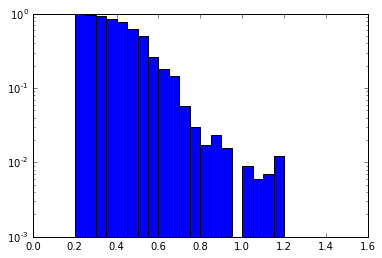

In [14]:
hist, bins = results.committor_histogram(distA, stateA, bins)
plt.bar(left=bins[:-1], height=hist, width=[bins[i+1]-bins[i] for i in range(len(bins)-1)], log=True)
plt.xlim(0.0, 1.6);

Here we've used the order parameter associated with state `A` as our collective variable. However, it is important to keep in mind that the choice of collective variable is completely arbitrary. For example, we could do the same analysis by looking at the distance from the central point `(0.0, 0.0)`. The plot would look different, since it is a different CV, but the procedure would remain the same.

This is important: because we have access to the whole snapshots, things that were not calculated during the data-generation phase can be calculated in the data-analysis phase.

### Committor as a function of two variables

Frequently, we're interested in looking at the committor as a function of two collective variables. This also follows the same procedure, although it is important that the new hashing function must return a tuple, where previously it returned a float. (Technically, it needs to return a hashable object. Tuples are hashable; lists, for example, are not.)

In [15]:
twoD_hash = lambda snap: (snap.xyz[0][0], snap.xyz[0][1])
bins = [-1.0+i*0.05 for i in range(41)]

In [16]:
hist, bins_x, bins_y = results.committor_histogram(twoD_hash, stateA, bins)

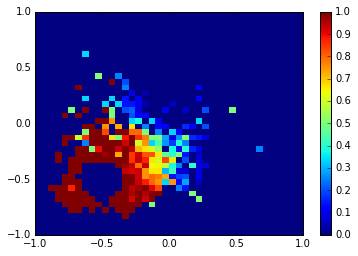

In [17]:
# when using pcolor, we need to transpose the histogram (hist.T)
plt.pcolor(bins_x, bins_y, hist.T)
plt.clim(0.0, 1.0)
plt.colorbar();